# Geospatial Taxi Demand Analysis

To analyze the taxi trip data of Chicago from the year 2015, this notebook will visualize the taxi usage in a geospatial context. Here different H3 maps with different resolutions (7, 8 and 9) and heatmaps are used. The analysis focuses on starting trips, ending trips, demand difference and idle time. 
Our H3 maps are not shown on GitHub so please refer to the uploaded notebook. The same goes for our heatmaps, which we can't upload due to its size.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMap
import h3
from shapely.geometry import Polygon
import geopandas
from geojson import Feature, Point, FeatureCollection, Polygon
from shapely.geometry import Polygon
import plotly.express as px
from datetime import datetime

First, we need to import all the essential libraries needed for our analysis. We'll work with two DataFrames (DFs):
Trips_df: This DataFrame contains the complete dataset for the H3 maps and includes the relevant features for our analysis.
Sample_df: Designed for the heatmaps, this DataFrame contains a sample of the entire dataset. Given the size of trips_df, we will use sample_df to generate the heatmaps.

In [2]:
#Import cleaned dataset

# For heatmaps use cleaned sample data
sample_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')

# For h3 maps use whole cleaned dataset
trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Cleaned.parquet')

# Columns to drop for trips_df
columns_to_drop = ['trip_seconds', 'trip_miles', 'pickup_census_tract', 'dropoff_census_tract', 'fare', 'tips', 'tolls', 'Extras', 'trip_total', 'payment_type', 'Company', 'temp', 'precip', 'is_weekday', 'h3_05_pickup',
       'h3_05_dropoff', 'h3_06_pickup', 'h3_06_dropoff', 'week_end']

trips_df = trips_df.drop(columns_to_drop, axis=1)

trips_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  pickup_community_area  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00                      8   
1        2  2015-01-01 00:30:00 2015-01-01 00:30:00                      8   
2        3  2015-01-01 00:30:00 2015-01-01 00:45:00                      8   

   dropoff_community_area  hour_start  4_hour_block_start  day_start  \
0                      32           0                   0          1   
1                       7           0                   0          1   
2                       8           0                   0          1   

   dayofweek_start  week_start  ...  month_end     h3_07_pickup  \
0                3           1  ...          1  872664c1effffff   
1                3           1  ...          1  872664c1effffff   
2                3           1  ...          1  872664c1effffff   

     h3_07_dropoff     h3_08_pickup    h3_08_dropoff     h3_09_pickup  \
0  872664c1effffff  882664c1e1fffff  882664c1e3fffff  892664c1e0fffff   
1  872664c13ffffff  882664c1e7fffff  882664c135fffff  892664c1e73ffff   
2  872664c13ffffff  882664c1e7fffff  882664c137fffff  892664c1e73ffff   

     h3_09_dropoff                     pickup_centroid  \
0  892664c1e2fffff  POINT (-87.626214906 41.892507781)   
1  892664c13cfffff   POINT (-87.63186395 41.892042136)   
2  892664c1377ffff   POINT (-87.63186395 41.892042136)   

                     dropoff_centroid   datetime  
0  POINT (-87.620992913 41.884987192) 2015-01-01  
1  POINT (-87.654007029 41.914747305) 2015-01-01  
2  POINT (-87.649907226 41.904935302) 2015-01-01  

[3 rows x 25 columns]

To make it easier to refer to specific locations in our analysis, we create a dictionary for each census tract name in Chicago and add it to our DataFrame. The list of census tracts has been retrieved from [here] (https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2000/pt6c-hxpp).

In [3]:
import csv

csv_file = '../../data/census_tract/chicago_census_tract.csv'

# Create an empty dictionary
data_dict = {}

# Open the CSV file
with open(csv_file, 'r') as file:
    reader = csv.reader(file)

    # Skip the header row if present
    next(reader)

    # Iterate over each row in the CSV file
    for row in reader:
        ca = row[1]  # CA is in the second column
        community = row[2]  # COMMUNIT_1 is in the third column

        # Add the data to the dictionary
        data_dict[ca] = community

data_dict = dict(sorted(data_dict.items(), key=lambda item: int(item[0])))
print(data_dict)

{'1': 'Rogers Park', '2': 'West Ridge', '3': 'Uptown', '4': 'Lincoln Square', '5': 'North Center', '6': 'Lake View', '7': 'Lincoln Park', '8': 'Near North Side', '9': 'Edison Park', '10': 'Norwood Park', '11': 'Jefferson Park', '12': 'Forest Glen', '13': 'North Park', '14': 'Albany Park', '15': 'Portage Park', '16': 'Irving Park', '17': 'Dunning', '18': 'Montclare', '19': 'Belmont Cragin', '20': 'Hermosa', '21': 'Avondale', '22': 'Logan Square', '23': 'Humboldt Park', '24': 'West Town', '25': 'Austin', '26': 'West Garfield Park', '27': 'East Garfield Park', '28': 'Near West Side', '29': 'North Lawndale', '30': 'South Lawndale', '31': 'Lower West Side', '32': 'Loop', '33': 'Near South Side', '34': 'Armour Square', '35': 'Douglas', '36': 'Oakland', '37': 'Fuller Park', '38': 'Grand Boulevard', '39': 'Kenwood', '40': 'Washington Park', '41': 'Hyde Park', '42': 'Woodlawn', '43': 'South Shore', '44': 'Chatham', '45': 'Avalon Park', '46': 'South Chicago', '47': 'Burnside', '48': 'Calumet Hei

In [4]:
# Create a new dictionary with integer keys
new_data_dict = {int(key): value for key, value in data_dict.items()}


In [5]:
key_types = [type(key) for key in new_data_dict.keys()]

In [6]:
# Match census tract name to community area unique value

# For heatmaps: sample df
sample_df['pickup_name'] = sample_df['pickup_community_area'].map(new_data_dict)
sample_df['dropoff_name'] = sample_df['dropoff_community_area'].map(new_data_dict)

# For h3 maps: trips_df
trips_df['pickup_name'] = trips_df['pickup_community_area'].map(new_data_dict)
trips_df['dropoff_name'] = trips_df['dropoff_community_area'].map(new_data_dict)
trips_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  pickup_community_area  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00                      8   
1        2  2015-01-01 00:30:00 2015-01-01 00:30:00                      8   
2        3  2015-01-01 00:30:00 2015-01-01 00:45:00                      8   

   dropoff_community_area  hour_start  4_hour_block_start  day_start  \
0                      32           0                   0          1   
1                       7           0                   0          1   
2                       8           0                   0          1   

   dayofweek_start  week_start  ...    h3_07_dropoff     h3_08_pickup  \
0                3           1  ...  872664c1effffff  882664c1e1fffff   
1                3           1  ...  872664c13ffffff  882664c1e7fffff   
2                3           1  ...  872664c13ffffff  882664c1e7fffff   

     h3_08_dropoff     h3_09_pickup    h3_09_dropoff  \
0  882664c1e3fffff  892664c1e0fffff  892664c1e2fffff   
1  882664c135fffff  892664c1e73ffff  892664c13cfffff   
2  882664c137fffff  892664c1e73ffff  892664c1377ffff   

                      pickup_centroid                    dropoff_centroid  \
0  POINT (-87.626214906 41.892507781)  POINT (-87.620992913 41.884987192)   
1   POINT (-87.63186395 41.892042136)  POINT (-87.654007029 41.914747305)   
2   POINT (-87.63186395 41.892042136)  POINT (-87.649907226 41.904935302)   

    datetime      pickup_name     dropoff_name  
0 2015-01-01  Near North Side             Loop  
1 2015-01-01  Near North Side     Lincoln Park  
2 2015-01-01  Near North Side  Near North Side  

[3 rows x 27 columns]

In [7]:
#Test for NAN values
trips_df['pickup_name'].isna().sum()

0

## Heatmaps 

In this section, we use heatmaps to visualize the number of starting trips and ending trips. However, due to the size of the heatmaps and kernel failures, we use only a sample of the data. As the size of the heatmap is still too big, we have removed the cell outputs containing the visualization of the heatmaps. Should your computing resources allow, you have the option to substitute the sample_df with the trips_df and execute the heatmap with the entire dataset.

### Starting Trips

In [8]:
from shapely import wkt

In [9]:
# Convert the pickup_centroid column to a GeoSeries from WKT format
sample_df["pickup_centroid"] = geopandas.GeoSeries.from_wkt(sample_df["pickup_centroid"])

In [10]:
sample_df.set_geometry('pickup_centroid')
sample_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00         540.0        0.17   
1        2  2015-01-01 00:00:00 2015-01-01 00:00:00         480.0        0.90   
2        3  2015-01-01 00:15:00 2015-01-01 00:30:00         780.0        5.50   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031080300           17031063301                      8   
1          17031320100           17031081500                     32   
2          17031281900           17031063301                     28   

   dropoff_community_area   fare  ...    h3_08_dropoff     h3_09_pickup  \
0                       6   7.25  ...  882664c101fffff  892664c13afffff   
1                       8   6.25  ...  882664c1e1fffff  892664c1e2fffff   
2                       6  14.05  ...  882664c101fffff  892664c1acfffff   

     h3_09_dropoff             pickup_centroid  \
0  892664c101bffff  POINT (-87.63576 41.90749)   
1  892664c1e0fffff  POINT (-87.62099 41.88499)   
2  892664c101bffff  POINT (-87.64265 41.87926)   

                     dropoff_centroid   datetime    temp  precip  \
0  POINT (-87.643022804 41.934539716) 2015-01-01 -7.0115       0   
1  POINT (-87.626214906 41.892507781) 2015-01-01 -7.0115       0   
2  POINT (-87.643022804 41.934539716) 2015-01-01 -7.0115       0   

       pickup_name     dropoff_name  
0  Near North Side        Lake View  
1             Loop  Near North Side  
2   Near West Side        Lake View  

[3 rows x 46 columns]

In [11]:
#Split pickup_centroid into coordinates
#taken from https://geopandas.org/en/stable/gallery/plotting_with_folium.html 

geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in sample_df.pickup_centroid]

In [12]:
# Create DF for starting trip locations and is corresponding area names
geo_df_pickup = geopandas.GeoDataFrame(geo_df_list, sample_df["pickup_census_tract"])
geo_df_pickup = geo_df_pickup.reset_index()
geo_df_pickup["pickup_name"] = sample_df["pickup_name"]

geo_df_pickup.head(3)

pickup_census_tract          0          1      pickup_name
0          17031080300  41.907492 -87.635760  Near North Side
1          17031320100  41.884987 -87.620993             Loop
2          17031281900  41.879255 -87.642649   Near West Side

In [ ]:
# Ploting heatmap that shows the census tracts and the frequency of trips starting there

trips_heatmap = folium.Map(
    location=(41.881832, -87.623177), # the orig mean values as location coordinates from https://www.latlong.net/place/chicago-il-usa-1855.html
    zoom_start=13,
    control_scale=True,
    max_zoom=20,
)

trips_heatmap.add_child(plugins.HeatMap(geo_df_list, radius=30))

popup_content = np.vectorize(
    lambda name, tract: f"Pickup Name: {name}<br> </br><br> Pickup Census Tract: {tract}"
)(geo_df_pickup['pickup_name'], geo_df_pickup['pickup_census_tract'])

for _,row in geo_df_pickup.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row[0], row[1]],
        popup=popup_content[_],
        color="crimson",
        fill_color="crimson",
    ).add_to(trips_heatmap)
    
    
trips_heatmap

The heatmap reveals that the primary hotspot is Loop, representing the city center. Additional hotspots include the O'Hare International Airport, as well as the Chicago Midway International Airport, both important transportation hubs in Chicago. Generally, it can be observed that besides the city center and the airports, taxi demand is elevated in the northern parts of Chicago, around Near North Side, Lake View, and Edgewater. In contrast, the southern regions display fewer prominent areas. More prominant locations in the South include the University of Chicago (located in Hyde Park) and Douglas.

## Ending Trips

In [13]:
# Convert the "dropoff_centroid" column to a GeoSeries from WKT format
sample_df["dropoff_centroid"] = geopandas.GeoSeries.from_wkt(sample_df["dropoff_centroid"])

In [14]:
sample_df.set_geometry('dropoff_centroid')
sample_df.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  trip_miles  \
0        1  2015-01-01 00:00:00 2015-01-01 00:00:00         540.0        0.17   
1        2  2015-01-01 00:00:00 2015-01-01 00:00:00         480.0        0.90   
2        3  2015-01-01 00:15:00 2015-01-01 00:30:00         780.0        5.50   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0          17031080300           17031063301                      8   
1          17031320100           17031081500                     32   
2          17031281900           17031063301                     28   

   dropoff_community_area   fare  ...    h3_08_dropoff     h3_09_pickup  \
0                       6   7.25  ...  882664c101fffff  892664c13afffff   
1                       8   6.25  ...  882664c1e1fffff  892664c1e2fffff   
2                       6  14.05  ...  882664c101fffff  892664c1acfffff   

     h3_09_dropoff             pickup_centroid            dropoff_centroid  \
0  892664c101bffff  POINT (-87.63576 41.90749)  POINT (-87.64302 41.93454)   
1  892664c1e0fffff  POINT (-87.62099 41.88499)  POINT (-87.62621 41.89251)   
2  892664c101bffff  POINT (-87.64265 41.87926)  POINT (-87.64302 41.93454)   

    datetime    temp  precip      pickup_name     dropoff_name  
0 2015-01-01 -7.0115       0  Near North Side        Lake View  
1 2015-01-01 -7.0115       0             Loop  Near North Side  
2 2015-01-01 -7.0115       0   Near West Side        Lake View  

[3 rows x 46 columns]

In [15]:
geo_df_list_dropoff = [[point.xy[1][0], point.xy[0][0]] for point in sample_df.dropoff_centroid]

In [16]:
geo_df_dropoff = geopandas.GeoDataFrame(geo_df_list_dropoff, sample_df["dropoff_census_tract"])

In [17]:
geo_df_dropoff = geo_df_dropoff.reset_index()
geo_df_dropoff["dropoff_name"] = sample_df["dropoff_name"]

geo_df_dropoff.head(3)

dropoff_census_tract          0          1     dropoff_name
0           17031063301  41.934540 -87.643023        Lake View
1           17031081500  41.892508 -87.626215  Near North Side
2           17031063301  41.934540 -87.643023        Lake View

In [ ]:
# Ploting heatmap that shows the census tracts and the frequency of trips ending there

trips_heatmap = folium.Map(
    location=(41.881832, -87.623177), # the orig mean values as location coordinates from https://www.latlong.net/place/chicago-il-usa-1855.html
    zoom_start=13,
    control_scale=True,
    max_zoom=20,
)

trips_heatmap.add_child(plugins.HeatMap(geo_df_list_dropoff, radius=30))

popup_content = np.vectorize(lambda name, tract: f"Dropoff Name: {name}<br> </br><br>Dropoff Census Tract: {tract}")(
    geo_df_dropoff['dropoff_name'], geo_df_dropoff['dropoff_census_tract']
)

for _,row in geo_df_dropoff.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row[0], row[1]],
        popup=popup_content[_],
        color="crimson",
        fill_color="crimson",
    ).add_to(trips_heatmap)
    
    
trips_heatmap

Similar to the heatmap of starting trips the most popular hotspot is Loop. Also the Airports and northern locations in Chicago are more prominent as well. The few popular locations in the south being around Hyde Park and Douglas. 

To further analyze patterns, like the similarity of starting and ending trips, we will use H3 maps and look at different analysis objectives. This should give us a more reliable foundation for pattern analysis because we can now examine the entire dataset. Furthermore, it allows us to assess whether the heatmaps created using the sample dataset accurately represent the broader patterns present in the data.

## H3 maps 

We use H3 maps to enhance our geospatial visualizations, focusing on resolution levels 7, 8, and 9 to capture different levels of detail. 
Our approach begins by establishing DataFrames for each resolution type, accompanied by methods for generating hexagonal geometries, counting the number of trips within each hexagon, and designing the visual representation of the H3 maps.


In [18]:
# Creating a dataframe that contains all hexagons where at least one trip started or ended

hexagons7_df = pd.DataFrame()
hexagons8_df = pd.DataFrame()
hexagons9_df = pd.DataFrame()

hexagons7_df["hex"] = pd.concat([trips_df["h3_07_pickup"], trips_df["h3_07_dropoff"]]).unique()
hexagons8_df["hex"] = pd.concat([trips_df["h3_08_pickup"], trips_df["h3_08_dropoff"]]).unique()
hexagons9_df["hex"] = pd.concat([trips_df["h3_09_pickup"], trips_df["h3_09_dropoff"]]).unique()
hexagons7_df.head(3)
hexagons8_df.head(3)
hexagons9_df.head(3)

hex
0  892664c1e0fffff
1  892664c1e73ffff
2  892664c1293ffff

In [19]:
# Defining a funtion that generates heaxagon geometry for each hexagon
# taken from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['hex'], True)
  return Polygon(points)

In [20]:
#Applying function to our hexagons dataframe

hexagons7_df['geometry'] = (hexagons7_df
                                .apply(add_geometry,axis=1)) 

hexagons8_df['geometry'] = (hexagons8_df
                                .apply(add_geometry,axis=1)) 

hexagons9_df['geometry'] = (hexagons9_df
                                .apply(add_geometry,axis=1)) 


hexagons7_df.head(3)


hex                                           geometry
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...

In [21]:
# Defining a functions that will count trips for a given groupby value

def calculate_hexagon_trips(hexagons_df, label, group_by):
    hexagons_df[label] = trips_df.groupby(group_by).size()
    hexagons_df[label] = hexagons_df[label].fillna(value=0)

In [22]:
# Calculate starting and ending trips for each hexagon

hexagons7_df = hexagons7_df.set_index('hex')
hexagons8_df = hexagons8_df.set_index('hex')
hexagons9_df = hexagons9_df.set_index('hex')


calculate_hexagon_trips(hexagons7_df, label="starting_trips_07", group_by="h3_07_pickup")
calculate_hexagon_trips(hexagons7_df, label="ending_trips_07", group_by="h3_07_dropoff")
calculate_hexagon_trips(hexagons8_df, label="starting_trips_08", group_by="h3_08_pickup")
calculate_hexagon_trips(hexagons8_df, label="ending_trips_08", group_by="h3_08_dropoff")
calculate_hexagon_trips(hexagons9_df, label="starting_trips_09", group_by="h3_09_pickup")
calculate_hexagon_trips(hexagons9_df, label="ending_trips_09", group_by="h3_09_dropoff")

hexagons7_df = hexagons7_df.reset_index()
hexagons8_df = hexagons8_df.reset_index()
hexagons9_df = hexagons9_df.reset_index()

hexagons9_df.head(3)

hex                                           geometry  \
0  892664c1e0fffff  POLYGON ((-87.62821283343483 41.89422009039776...   
1  892664c1e73ffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2  892664c1293ffff  POLYGON ((-87.6609277473747 41.938599432639094...   

   starting_trips_09  ending_trips_09  
0          1539532.0        1172276.0  
1           998728.0         805638.0  
2            15996.0          32308.0

In [23]:
hexagons7_df["pickup_name"]=trips_df["pickup_name"]
hexagons8_df["pickup_name"]=trips_df["pickup_name"]
hexagons9_df["pickup_name"]=trips_df["pickup_name"]

hexagons7_df.head(3)

hex                                           geometry  \
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   

   starting_trips_07  ending_trips_07      pickup_name  
0          7532228.0          6705006  Near North Side  
1           122202.0           283480  Near North Side  
2           575439.0           808271  Near North Side

In [24]:
# Our approach uses the chloropleth_mapbox module of Plotly Express to build a map.
# To do this a GeoJSON-formatted dictionary is created by this method that can be passed to Plotly express. 

# taken from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def hexagons_dataframe_to_geojson(df_hex, value_field, file_output = None):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row['geometry'],
                          id = row['hex'],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)

    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)

    else :
      return feat_collection

In [25]:
# Function that visualizes the H3 map

# Adapted from https://medium.com/analytics-vidhya/how-to-create-a-choropleth-map-using-uber-h3-plotly-python-458f51593548

def plot_frequency(dataset, variable, labels, range_color, palette="RdBu"):
    geojson_obj = (hexagons_dataframe_to_geojson(dataset, value_field=variable))

    fig = (px.choropleth_mapbox(
                    dataset,
                    width=700,
                    height=500,
                    geojson=geojson_obj, 
                    locations='hex', 
                 #   hover_name = "pickup_name",
                    color=variable,
                    color_continuous_scale=palette,
                    range_color=range_color,
                    mapbox_style='carto-positron',
                    zoom=10.5,
                    center = {"lat": 41.881832 ,"lon": -87.623177,},
                    opacity=0.7,
                    labels=labels))
    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
    )
    return fig 

In [26]:
# Function to plot the frequency with choropleth colors based on the variable

def plot_frequency_test(dataset, hover_name, variable, labels, range_color, palette="RdBu"):
    fig = (px.choropleth_mapbox(
        dataset,
        width=700,
        height=500,
        geojson=hexagons_dataframe_to_geojson(dataset, value_field=variable),
        locations='hex',
        hover_name=hover_name,
        color=variable,  # Use the 'variable' directly as the color
        color_continuous_scale=palette,
        range_color=range_color,
        zoom=10.5,
        center={"lat": 41.881832, "lon": -87.623177},
        opacity=0.7,
        labels=labels,
        animation_frame="month",
       # animation_group="hex",
        mapbox_style="open-street-map",
    ))
    fig.update_layout(
        sliders=[
            dict(
                active=0,
                bgcolor='black'
            )
        ]
    )
    return fig


# Hex7

First we begin by visualizing the hexagon resolution 7. In each resolution type, we examine both the count of starting and ending trips, as well as the demand difference. We will take a closer look at the difference in demand by looking at the total difference, as well as the morning (6am-12pm) and evening (2pm-8pm) differences.

We will use a quantile of 0.9 for the color range. However, for visualizations where differences are less noticeable, we will adjust the quantile to 0.95 to emphasize the variations more clearly.

## Starting Trips

In [27]:
variable = "starting_trips_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Starting Trips in Res7"},
    range_color=(0, hexagons7_df[variable].quantile(0.9)),
    palette="reds",
)

fig.show()

It is visible that the most taxi trips start in the city center, like Loop, Lincoln Park, West Town and Near South Side. These regions are bustling commercial and residential hubs, drawing both locals and visitors for various activities and destinations. As highlighted in the **POI notebook**, these hexagons contain several points of interest related to sustenance, arts and culture, as well as sports.
Furthermore, two other prominent destinations stand out — Airport O'Hare and Clearing. These locations are logical hotspots due to their roles as major transportation hubs, attracting a substantial volume of travelers arriving or departing from the city.

## Ending Trips

In [28]:
variable = "ending_trips_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Ending Trips in Res7"},
    range_color=(0, hexagons7_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Just like with the heatmaps we see a notable similarity between where taxi journeys begin and where they conclude on the map. This similarity suggests a connection between popular starting points and destinations across the city. This can lead to both commencing their journeys and completing them within the central areas. Rather than dispersing to other regions before leaving, many opt to stay within the center. In addition, the prominence of transportation hubs such as Airport O'Hare and Clearing naturally contributes to their dual role as popular starting and ending points. These hubs are central and accessible nodes for incoming and outgoing travel, making their significance self-explanatory.

## Demand Difference

To compute the demand difference, we will subtract the count of ending trips from that of starting trips. Hence a positive demand difference in a hexagon means that there are more starting than ending trips, are presented by blue shade colors. Vice versa, red colored hexagons visualize locations where more ending trips happen and have a negative number. 

### Overall

In [29]:
# Calculate demand difference
hexagons7_df["demand_difference_07"] = hexagons7_df["starting_trips_07"] - hexagons7_df["ending_trips_07"]
hexagons7_df.head(3)

hex                                           geometry  \
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   

   starting_trips_07  ending_trips_07      pickup_name  demand_difference_07  
0          7532228.0          6705006  Near North Side              827222.0  
1           122202.0           283480  Near North Side             -161278.0  
2           575439.0           808271  Near North Side             -232832.0

In [30]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_07"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand difference in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.95),
        hexagons7_df[variable].quantile(0.95),
    ),
)
fig.show()

To see the differences on the H3 map better, we used a 0.95 quantile instead of 0.9. The overall demand difference is only positive for a few hexagons: Airport O'Hare and Midway (in Clearing), Jefferson Park, Loop and Brighton Park. Else the demand difference is negative or zero. For places more in the south of Chicago and more on the periphery have a lower demand difference, so the ending trips are not as prominent as the other places. This could be due to reason that outskirts are less habitated than places closer to the city. To look further at the possible reasons why there is a bigger negative demand difference, we will look at different time zones.

### During morning and evening rush hour

In [31]:
# Function that returns the number of trips for the given hours and for the given 'group by' value

def calculate_hexagon_trips_by_hours(hexagons_df, label, group_by, hours):
    hexagons_df[label] = (
        trips_df[
            (trips_df["trip_start_timestamp"].dt.hour >= hours[0])
            & (trips_df["trip_start_timestamp"].dt.hour <= hours[1])
        ]
        .groupby(group_by)
        .size()
    )
    hexagons_df[label] = hexagons_df[label].fillna(value=0)

In [32]:
# Function that returns the number of trips for the given hours and for the given 'group by' value

def calculate_hexagon_trips_hour(hexagons_df, hexagon_num):
    hexagon_label = f"h3_0{hexagon_num}"
    now = datetime.now()
    morning_hours = [now.replace(hour=6).hour, now.replace(hour=12).hour]
    evening_hours = [now.replace(hour=14).hour, now.replace(hour=20).hour]

    calculate_hexagon_trips_by_hours(
        hexagons_df, label="starting_trips_morning", group_by=f"{hexagon_label}_pickup", hours=morning_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "ending_trips_morning", group_by=f"{hexagon_label}_dropoff", hours=morning_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "starting_trips_evening", group_by=f"{hexagon_label}_pickup", hours=evening_hours
    )
    calculate_hexagon_trips_by_hours(
        hexagons_df, label= "ending_trips_evening", group_by=f"{hexagon_label}_dropoff", hours=evening_hours
    )

    hexagons_df["trips_difference_morning"] = (
        hexagons_df["starting_trips_morning"] - hexagons_df["ending_trips_morning"]
    )
    hexagons_df["trips_difference_evening"] = (
        hexagons_df["starting_trips_evening"] - hexagons_df["ending_trips_evening"]
    )

    return hexagons_df

In [33]:
# Calculate the difference between starting and ending trips for the morning (06:00-12:00) 
# and for the evening (14:00-20:00) in Resolution 7, 8 + 9

hexagon_numbers = [7, 8, 9]
for hexagon_num in hexagon_numbers:
    hexagon_df = globals()[f"hexagons{hexagon_num}_df"]
    hexagon_df = hexagon_df.set_index("hex")
    hexagon_df = calculate_hexagon_trips_hour(hexagon_df, hexagon_num)
    hexagon_df = hexagon_df.reset_index()

    # Optionally, you can assign the updated DataFrame back to its original variable
    globals()[f"hexagons{hexagon_num}_df"] = hexagon_df

hexagons7_df.head(3)

#hexagons7_df['geometry'] = hexagons7_df['geometry'].apply(lambda geom: geom.wkt) 
#hexagons7_df.to_parquet('hexagons7_df.parquet', index=False)


hex                                           geometry  \
0  872664c1effffff  POLYGON ((-87.63048927308355 41.90755371098675...   
1  872664c12ffffff  POLYGON ((-87.6723729663648 41.93963771855481,...   
2  872664c10ffffff  POLYGON ((-87.6427881340186 41.94402243665091,...   

   starting_trips_07  ending_trips_07      pickup_name  demand_difference_07  \
0          7532228.0          6705006  Near North Side              827222.0   
1           122202.0           283480  Near North Side             -161278.0   
2           575439.0           808271  Near North Side             -232832.0   

   starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0               2021698.0             1737991.0               3189688.0   
1                  6240.0               13771.0                 39852.0   
2                142213.0               49264.0                196926.0   

   ending_trips_evening  trips_difference_morning  trips_difference_evening  
0             2998390.0                  283707.0                  191298.0  
1              112164.0                   -7531.0                  -72312.0  
2              350817.0                   92949.0                 -153891.0

In [34]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand Difference Morning in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.9),
        hexagons7_df[variable].quantile(0.9),
    ),
)
fig.show()

In the morning (6am-12pm) the overall demand difference in most parts of Chicago is neither high on the positive or negative. This could be attributed to a balance between people starting their day and those who have already reached their destinations. The two Airports have more ending trips, which could be due to the fact that the early morning hours are often popular for business travel.
Around Loop, Near North Side, Douglas and Lincoln Park there are also more ending trips, assumingly also due to work reasons, as there could be more businesses located.
Around Hyde Park, we see a mix of more starting and ending trips. Reasons for this pattern could be: The University of Chicago and nearby educational institutions drive up starting trips as students and faculty commute, as well as possible residential areas. The museums and parks can also attract visitors who kickstart their day with trips to these attractions leading to more ending trips. 
In the North of Chicago, next to the river side, there are more starting trips, which is likely also due to to these areas being residential neighborhoods, as well as Public Transport not being as present in these areas (see **POI Notbeook**).

In [35]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons7_df,
    variable=variable,
    labels={variable: "Demand Difference Evening in Res7"},
    range_color=(
        -hexagons7_df[variable].quantile(0.9), 
        hexagons7_df[variable].quantile(0.9),
    ),
)
fig.show()

A big difference is visible in comparison to the demand difference in the morning. In the evening (14pm-20pm) the demand difference is negative for most part in Chicago. This could be because people come back from work or activities that they did in the evening, like shopping or dining out. 
The two Airports in O'Hare and Clearing have more starting trips, as people come back from work trips or vacation on a later time. 
On a lot of the peripheral parts of Chicago again there is no much demand difference, likely because of lower urban denisty and less activity options.
Here we can also see Elk Grove Village being prominent for the first time. This place has different kinds of outdoor activities and seems to be mostly visited during evening time. With its family-oriented activities, it's plausible that people choose to visit this area after school or work hours.

# Hex8

Next, we will look at resolution 8 to capture finer geographic details.

In [36]:
variable = "starting_trips_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Starting Trips in Res8"},
    range_color=(0, hexagons8_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Overall the Resolution 8 H3 map is very similar to the Resolution 7 map. The primary distinction lies in a few more differentiating features within the city center and the northern region. Notably, the area around Hyde Park has gained more visual prominence. 

In [37]:
variable = "ending_trips_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Ending Trips in Res8"},
    range_color=(0, hexagons8_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

Once again, a similar pattern emerges as in Resolution 7. We observe increased dynamics within the city center and the northern regions, including areas like Lincoln Park and Uptown. Hyde Park also gains enhanced visibility in this resolution.

In [38]:
hexagons8_df["demand_difference_08"] = hexagons8_df["starting_trips_08"] - hexagons8_df["ending_trips_08"]
hexagons8_df.head(3)

hex                                           geometry  \
0  882664c1e1fffff  POLYGON ((-87.62574462750952 41.90005311598093...   
1  882664c1e7fffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2  882664c129fffff  POLYGON ((-87.6609277473747 41.938599432639094...   

   starting_trips_08  ending_trips_08      pickup_name  \
0          2114950.0        1698901.0  Near North Side   
1           998728.0         805638.0  Near North Side   
2            25830.0          54022.0  Near North Side   

   starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0                532833.0              390832.0                902181.0   
1                156883.0              182964.0                337845.0   
2                  1542.0                1915.0                  8055.0   

   ending_trips_evening  trips_difference_morning  trips_difference_evening  \
0              816582.0                  142001.0                   85599.0   
1              350695.0                  -26081.0                  -12850.0   
2               19907.0                    -373.0                  -11852.0   

   demand_difference_08  
0              416049.0  
1              193090.0  
2              -28192.0

In [39]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_08"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand difference Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.95),
        hexagons8_df[variable].quantile(0.95),
    ),
)
fig.show()

Contrary to Resolution 7, we notice in Resolution 8 that the peripheral areas exhibit lower demand differences. This aligns with the earlier observations in Resolution 8 and 7, indicating a general scarcity of both starting and ending trips in these outer regions. One explanation for this pattern, besides the lower population density, could be the increased availability of public transport in these areas, particularly in the South. This option may be favored due to its cost-effectiveness compared to taking a taxi to the city center.

### During morning and evening rush hour

In [40]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand Difference Morning Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.9),
        hexagons8_df[variable].quantile(0.9),
    ),
)
fig.show()

Interestingly, this resolution provides more detailed insights into the distribution of starting and ending trips in Chicago, particularly within the city center, as well as around Lincoln Park and Lake View.

In [41]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons8_df,
    variable=variable,
    labels={variable: "Demand Difference Evening Res8"},
    range_color=(
        -hexagons8_df[variable].quantile(0.95),
        hexagons8_df[variable].quantile(0.95),
    ),
)
fig.show()

Once again, this map exhibits a resemblance to Resolution 7, but it offers a clearer distinction of areas with higher starting trips within the broader red-colored regions, indicating locations where Taxi trips end more frequently than they start.

Overall, we can observe patterns within Chicago that remain uncolored on the map, due to the increased level of detail provided by a higher hexagon resolution. This aspect already offers insights into locations with no Taxi trips, and we expect this distinction to be even more refined with Resolution 9.

# Hex9

Finally, we will look at Resolution 9 to analyze taxi demand in more detail. Since these maps are just a more detailed version of the other two Resolutions, showing more exact locations due to smaller hexagon sizes where certain hexagons are not drawn anymore, we will only comment on the maps where a bigger difference is visible.

In [42]:
variable = "starting_trips_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Starting Trips in Res9"},
    range_color=(0, hexagons9_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

In [43]:
variable = "ending_trips_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Ending Trips in Res9"},
    range_color=(0, hexagons9_df[variable].quantile(0.9)),
    palette="reds"
)

fig.show()

In [44]:
hexagons9_df["demand_difference_09"] = hexagons9_df["starting_trips_09"] - hexagons9_df["ending_trips_09"]
hexagons9_df.head(3)

hex                                           geometry  \
0  892664c1e0fffff  POLYGON ((-87.62821283343483 41.89422009039776...   
1  892664c1e73ffff  POLYGON ((-87.63243550733023 41.89359528834631...   
2  892664c1293ffff  POLYGON ((-87.6609277473747 41.938599432639094...   

   starting_trips_09  ending_trips_09      pickup_name  \
0          1539532.0        1172276.0  Near North Side   
1           998728.0         805638.0  Near North Side   
2            15996.0          32308.0  Near North Side   

   starting_trips_morning  ending_trips_morning  starting_trips_evening  \
0                393617.0              254651.0                627969.0   
1                156883.0              182964.0                337845.0   
2                   973.0                 932.0                  4674.0   

   ending_trips_evening  trips_difference_morning  trips_difference_evening  \
0              558964.0                  138966.0                   69005.0   
1              350695.0                  -26081.0                  -12850.0   
2               11863.0                      41.0                   -7189.0   

   demand_difference_09  
0              367256.0  
1              193090.0  
2              -16312.0

In [45]:
# Ploting a map with hexagons depicting the difference in demand considering starting and ending trips

variable = "demand_difference_09"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand difference Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.95),
        hexagons9_df[variable].quantile(0.95),
    ),
)
fig.show()

### During morning and evening rush hour

In [46]:
# Ploting a map with hexagons depicting the demand difference in the morning

variable = "trips_difference_morning"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand Difference Morning Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.9),
        hexagons9_df[variable].quantile(0.9),
    ),
)
fig.show()

In [47]:
# Ploting a map with hexagons depicting the demand difference in the evening

variable = "trips_difference_evening"

fig = plot_frequency(
    dataset=hexagons9_df,
    variable=variable,
    labels={variable: "Demand Difference Evening Res9"},
    range_color=(
        -hexagons9_df[variable].quantile(0.95),
        hexagons9_df[variable].quantile(0.95),
    ),
)
fig.show()

In [48]:
hexagons9_df['geometry'] = hexagons9_df['geometry'].apply(lambda geom: geom.wkt) 
hexagons9_df.to_parquet('hexagons9_df.parquet', index=False)

Given the absence of comments on any of the H3 Resolution 9 maps, it can be conlcuded that Resolution 9 just captures more precise locations. On the other hand, Resolutions 7 and 8 seem to have effectively captured the broader essential patterns and insights.

# Average idle time between trips

When considering Taxis in Chicago, studying idle time is crucial because it unveils moments when taxis are not in active service, waiting for passengers. Analyzing idle time patterns can offer valuable information about taxi supply and demand dynamics, helping to identify areas or times of low passenger activity. This insight can guide Taxi operators in making informed decisions to strategically position taxis, minimize empty driving, and optimize earnings for both drivers and the overall Taxi system.

In [49]:
# Method for visualizing average idle time in a hex map
def plot_trips_net_monthly(h3_res: int, time_interval_length: int):
	trips_monthly_net = get_trips_net_monthly(h3_res, time_interval_length)

	trips_monthly_net['month'] = trips_monthly_net['datetime'].dt.month
	trips_monthly_net = trips_monthly_net.sort_values(by=['month'])

	h3_visualization.plot_choropleth(
		trips_monthly_net,
		hex_col="hex_id",
		color_by_col="demand",
		center=lat_lon_leipzig,
		color_continuous_scale="RdBu",
		range_color=(
			-50,
			50
		),
		animation_frame="month",
		opacity=0.7,
		zoom=10,
		labels={'demand': 'inflow - outflow'},
		mapbox_style="open-street-map",
	)

In [50]:
# Shift trips, so the idle time of a taxi can be calculated later on
trips_shifted = trips_df.groupby("taxi_id").shift(1).dropna(subset=["trip_start_timestamp"])
trips_with_next = trips_df.merge(
    trips_shifted, left_index=True, right_index=True, how="inner", suffixes=("", "_next")
)
trips_with_next['taxi_id'] = trips_df['taxi_id']

In [51]:
# Calculating idle time
trips_with_next['idle_time'] = (
    trips_with_next.trip_end_timestamp - trips_with_next.trip_start_timestamp_next
)

In [52]:
trips_with_next.idle_time.describe()

count                     17061046
mean     0 days 02:31:37.555231959
std      0 days 15:14:56.012201881
min              -1 days +13:00:00
25%                0 days 00:00:00
50%                0 days 01:00:00
75%                0 days 01:45:00
max              295 days 10:45:00
Name: idle_time, dtype: object

In [53]:
trips_with_next['timeinterval'] = (
    trips_with_next.trip_start_timestamp.dt.floor('1D')
)

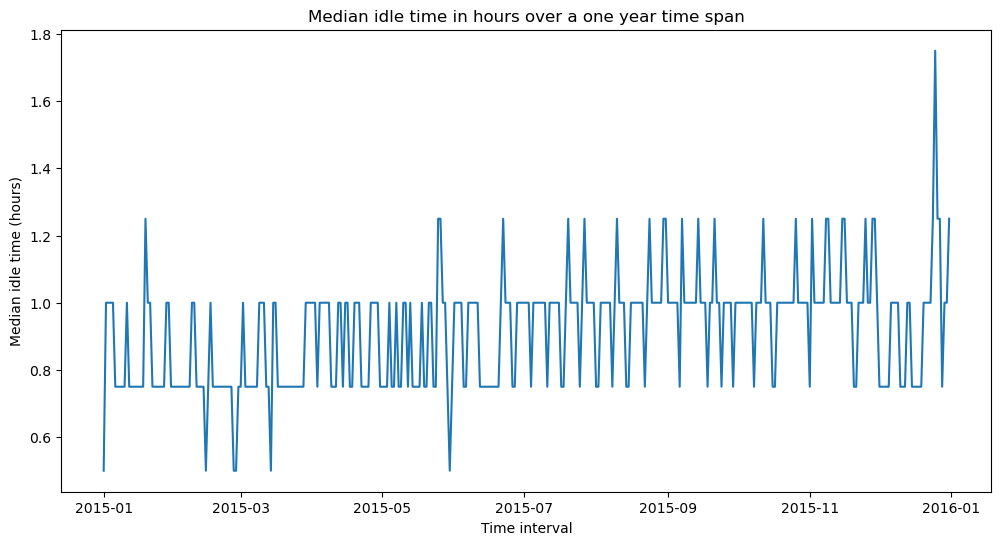

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    trips_with_next.groupby("timeinterval").idle_time.median().dt.total_seconds()
    / 60
    / 60,
)
ax.set_xlabel("Time interval")
ax.set_ylabel("Median idle time (hours)")
ax.set_title("Median idle time in hours over a one year time span")

plt.show()

With a linear plot we show the median idle time in hours for the one year period. The median idle time is overall very similar. We can see a bigger idle time around December, which could be attributed to holiday-related changes in travel demand. In our **Temporal Demand Pattern Notebook** we also observed that there are less Taxi usages in December. Additionally other short peaks during End of June to November can be seen, possibly due to seasonal events or factors influencing travel behavior, and one around January, likely related to weather conditions. For these month we also observed less Taxi usage.
Around January to March smaller idle times can be seen, this phenomenon can be attributed to the colder weather prevalent in Chicago during this period. Around June a smaller idle time can also be observed. Conversely, in June, a reduction in idle time is discernible. This trend can be attributed to the onset of warmer weather, likely leading to more outdoor activities and higher demand for transportation services, thus reducing taxi idle times during this period.

In [55]:
trips_with_next.head(3)

taxi_id trip_start_timestamp  trip_end_timestamp  pickup_community_area  \
37       12  2015-01-01 00:30:00 2015-01-01 00:45:00                     32   
48       32  2015-01-01 00:30:00 2015-01-01 00:30:00                      6   
49        8  2015-01-01 00:30:00 2015-01-01 00:45:00                      7   

    dropoff_community_area  hour_start  4_hour_block_start  day_start  \
37                       8           0                   0          1   
48                       6           0                   0          1   
49                       7           0                   0          1   

    dayofweek_start  week_start  ...  h3_08_dropoff_next  h3_09_pickup_next  \
37                3           1  ...     882664c1e3fffff    892664c1e33ffff   
48                3           1  ...     882664c1e3fffff    892664c1217ffff   
49                3           1  ...     882664c129fffff    892664c105bffff   

    h3_09_dropoff_next                pickup_centroid_next  \
37     892664c1e2fffff  POINT (-87.618868355 41.890922026)   
48     892664c1e33ffff  POINT (-87.665676837 41.928763006)   
49     892664c1293ffff  POINT (-87.651562592 41.936310131)   

                 dropoff_centroid_next  datetime_next pickup_name_next  \
37  POINT (-87.620992913 41.884987192)     2015-01-01  Near North Side   
48  POINT (-87.618868355 41.890922026)     2015-01-01     Lincoln Park   
49  POINT (-87.661265218 41.936159071)     2015-01-01        Lake View   

   dropoff_name_next       idle_time timeinterval  
37              Loop 0 days 00:15:00   2015-01-01  
48   Near North Side 0 days 00:00:00   2015-01-01  
49         Lake View 0 days 00:15:00   2015-01-01  

[3 rows x 55 columns]

In [56]:
trips_with_next['month'] = trips_with_next.trip_start_timestamp.dt.month

In [57]:
# Hex7
idle_by_hex7_time_median = trips_with_next.groupby(["h3_07_pickup_next", "month"])[
    "idle_time"
].median().rename("idle_time_median")
idle_by_hex7_time_mean = trips_with_next.groupby(["h3_07_pickup_next", "month"])[
    "idle_time"
].mean().rename("idle_time_mean")

idle_by_hex7_time = pd.concat(
	[idle_by_hex7_time_median, idle_by_hex7_time_mean], axis=1
).reset_index()

# Hex9
idle_by_hex9_time_median = trips_with_next.groupby(["h3_09_pickup_next", "month"])[
    "idle_time"
].median().rename("idle_time_median")
idle_by_hex9_time_mean = trips_with_next.groupby(["h3_09_pickup_next", "month"])[
    "idle_time"
].mean().rename("idle_time_mean")

idle_by_hex9_time = pd.concat(
	[idle_by_hex9_time_median, idle_by_hex9_time_mean], axis=1
).reset_index()

In [58]:
# Hex7
idle_by_hex7_time["idle_time_median_days"] = (
    idle_by_hex7_time["idle_time_median"].dt.total_seconds() / 60 / 60 / 24
)
idle_by_hex7_time["idle_time_mean_days"] = (
    idle_by_hex7_time["idle_time_mean"].dt.total_seconds() / 60 / 60 / 24
)

# Hex9
idle_by_hex9_time["idle_time_median_days"] = (
    idle_by_hex9_time["idle_time_median"].dt.total_seconds() / 60 / 60 / 24
)
idle_by_hex9_time["idle_time_mean_days"] = (
    idle_by_hex9_time["idle_time_mean"].dt.total_seconds() / 60 / 60 / 24
)

In [59]:
idle_by_hex7 = idle_by_hex7_time.groupby("h3_07_pickup_next").mean().reset_index()

# Hex9
idle_by_hex9 = idle_by_hex9_time.groupby("h3_09_pickup_next").mean().reset_index()

/var/folders/9w/m9xdz1rs3gb300n40q8vf0fm0000gq/T/ipykernel_87586/1034988048.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/9w/m9xdz1rs3gb300n40q8vf0fm0000gq/T/ipykernel_87586/1034988048.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [60]:
# Hex7
idle_by_hex7.rename(columns={"h3_07_pickup_next":"hex"}, inplace=True)
idle_by_hex7_time.rename(columns={"h3_07_pickup_next":"hex"}, inplace=True)

# Hex9
idle_by_hex9.rename(columns={"h3_09_pickup_next":"hex"}, inplace=True)
idle_by_hex9_time.rename(columns={"h3_09_pickup_next":"hex"}, inplace=True)

In [61]:
import math
# Hex7
idle_by_hex7['month'] = idle_by_hex7['month'].astype(int)

idle_by_hex7.head(3)

# Hex9
idle_by_hex9['month'] = idle_by_hex9['month'].astype(int)

idle_by_hex9.head(3)

hex  month  idle_time_median_days  idle_time_mean_days
0  8926641962fffff     10               0.062500             0.062500
1  8926645204fffff      1               0.255208             0.255208
2  89266452133ffff      7               0.221354             0.221354

In [62]:
# Hex7
idle_by_hex7['geometry'] = (idle_by_hex7.apply(add_geometry,axis=1)) 
idle_by_hex7_time['geometry'] = (idle_by_hex7.apply(add_geometry,axis=1)) 

# Hex9
idle_by_hex9['geometry'] = (idle_by_hex9.apply(add_geometry,axis=1)) 
idle_by_hex9_time['geometry'] = (idle_by_hex9.apply(add_geometry,axis=1)) 

In [63]:
# Hex7
idle_by_hex7_time['geometry'].isna().sum()
idle_by_hex7_time = idle_by_hex7_time.dropna(axis=0)
idle_by_hex7_time.head(3)

# Hex9
idle_by_hex9_time['geometry'].isna().sum()
idle_by_hex9_time = idle_by_hex9_time.dropna(axis=0)
idle_by_hex9_time.head(3)

hex  month idle_time_median  idle_time_mean  \
0  8926641962fffff      9  0 days 02:00:00 0 days 02:00:00   
1  8926641962fffff     12  0 days 01:00:00 0 days 01:00:00   
2  8926645204fffff      1  0 days 06:07:30 0 days 06:07:30   

   idle_time_median_days  idle_time_mean_days  \
0               0.083333             0.083333   
1               0.041667             0.041667   
2               0.255208             0.255208   

                                            geometry  
0  POLYGON ((-87.57094300713293 41.68425814685267...  
1  POLYGON ((-87.79205310273258 41.79607137952077...  
2  POLYGON ((-87.75253332434804 41.77739208105741...

As there is little difference from Resolution 7 to 8, we will just visualize Resolution 7 and 9.

In [68]:
idle_by_hex7 = idle_by_hex7.sort_values('month')

variable = "idle_time_median_days"

fig = plot_frequency(
    dataset=idle_by_hex7,
    variable=variable,
    labels={variable: "Idle Time in Res7"},
    range_color=(0, idle_by_hex7[variable].quantile(0.9)),
    palette="reds",

)

fig.show()

It can be observed that there is a higher idle time around peripheral areas in Chicago, possibly due to the patterns we have seen in the previous analysis, namely lower number of starting and ending trips, indicating a lower taxi demand in these regions. Possible reasons that we mentioned were due to alternative transportation options, longer distances resulting in higher fares, and lower resident population.

In [67]:
idle_by_hex9 = idle_by_hex9.sort_values('month')

variable = "idle_time_median_days"

fig = plot_frequency(
    dataset=idle_by_hex9,
    variable=variable,
    labels={variable: "Idle Time in Res9"},
    range_color=(0, idle_by_hex9[variable].quantile(0.9)),
    palette="reds",

)

fig.show()

Finally, with a Resolution of 9, we can see in more detail in which locations the idle time is higher or lower. This again is already well captured in Resolution 7, as both are similar. 